In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_selection import mutual_info_classif

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

# installments_payments

In [2]:
installments_payments = help_tool.csv_download(r'Archive\home-credit-default-risk\installments_payments.csv')
help_tool.first_look(installments_payments)

Dataset has 13605401 observations and 8 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_PREV,int64,0,0.0
SK_ID_CURR,int64,0,0.0
NUM_INSTALMENT_VERSION,float64,0,0.0
NUM_INSTALMENT_NUMBER,int64,0,0.0
DAYS_INSTALMENT,float64,0,0.0
DAYS_ENTRY_PAYMENT,float64,2905,0.0
AMT_INSTALMENT,float64,0,0.0
AMT_PAYMENT,float64,2905,0.0


In [3]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## Null values
Null values take less than 0%, 2905 rows. Payment day (DAYS_ENTRY_PAYMENT) is missing when payment amount is missing.

In [4]:
installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].isnull() & installments_payments['AMT_PAYMENT'].notna()]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT


Let's investigate when missing rows appear. Missing values will be imputed with -1 and 0 (impossible values) for AMT_PAYMENT and DAYS_ENTRY_PAYMENT respectively.

In [5]:
# Creating a new dataframe for ids of null values
installments_payments_missing = installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].isnull() & (installments_payments['AMT_INSTALMENT'] > 1)][['SK_ID_CURR', 'SK_ID_PREV']].value_counts().to_frame().reset_index()
installments_payments_copy = installments_payments[installments_payments['SK_ID_PREV'].isin(installments_payments_missing['SK_ID_PREV'].tolist())]

# Encoding missing values
installments_payments_copy.loc[installments_payments_copy['AMT_PAYMENT'].isna(), 'AMT_PAYMENT'] = -1
installments_payments_copy.loc[installments_payments_copy['DAYS_ENTRY_PAYMENT'].isna(), 'DAYS_ENTRY_PAYMENT'] = 0

# List of top 10 ids of missing values
top_missing_ids = installments_payments_copy[installments_payments_copy['SK_ID_PREV'].isin(installments_payments_missing['SK_ID_PREV'].head(10).tolist())]

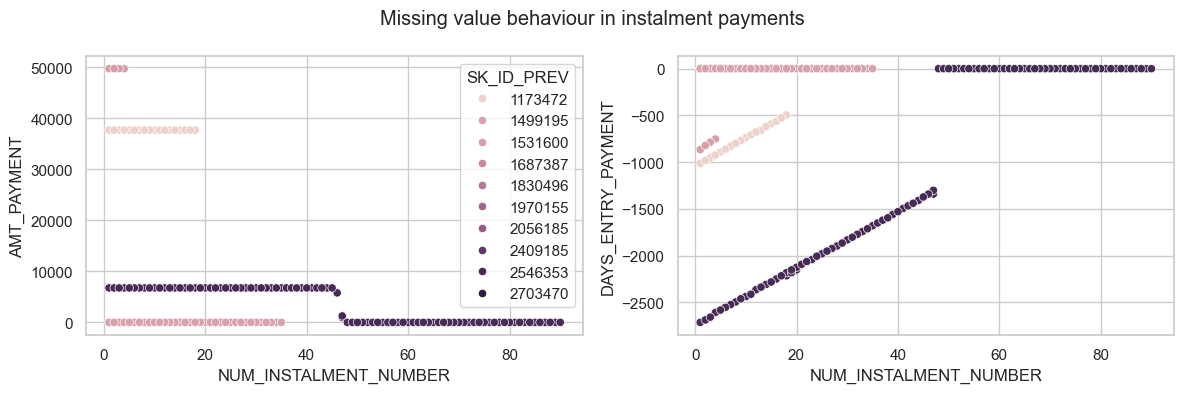

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 

sns.scatterplot(ax=axes[0], data=top_missing_ids, y='AMT_PAYMENT', x='NUM_INSTALMENT_NUMBER', hue='SK_ID_PREV', legend='full')
sns.scatterplot(ax=axes[1], data=top_missing_ids, y='DAYS_ENTRY_PAYMENT', x='NUM_INSTALMENT_NUMBER', hue='SK_ID_PREV', legend=False)

fig.suptitle('Missing value behaviour in instalment payments')

plt.tight_layout()
plt.show()

It is seen that values drop to imputed near 0 value, at the second half of the planned instalments. Imputing null value could muddy the waters on instalment payments behavious. Null values will be dropped.

In [7]:
installments_payments = installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].notna()]

## EDA
Dataset represented by 100000 random rows, which is enough for distribution check.

NUM_INSTALMENT_VERSION


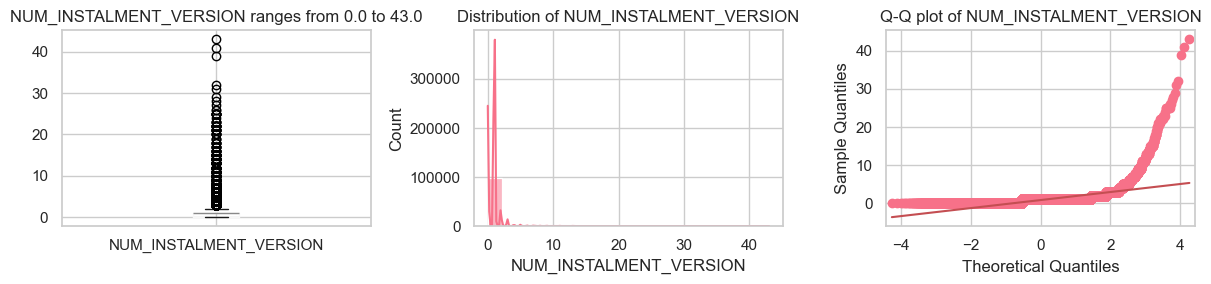

NUM_INSTALMENT_NUMBER


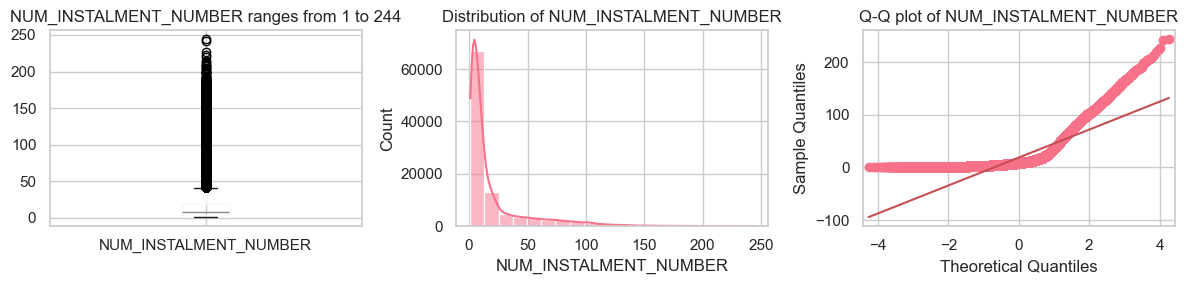

AMT_INSTALMENT


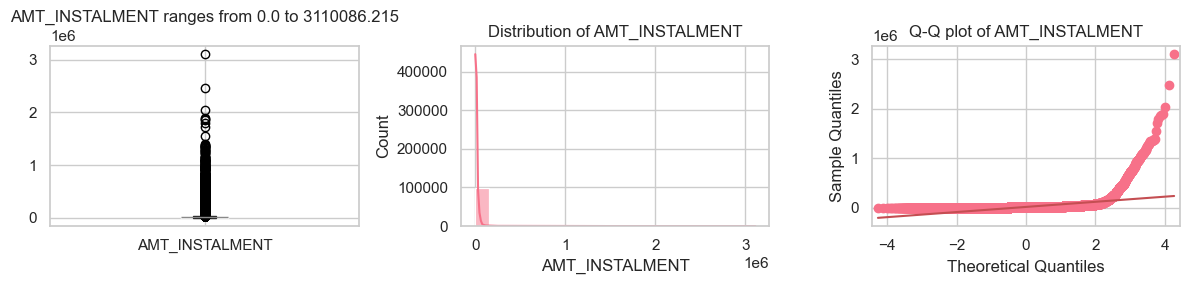

AMT_PAYMENT


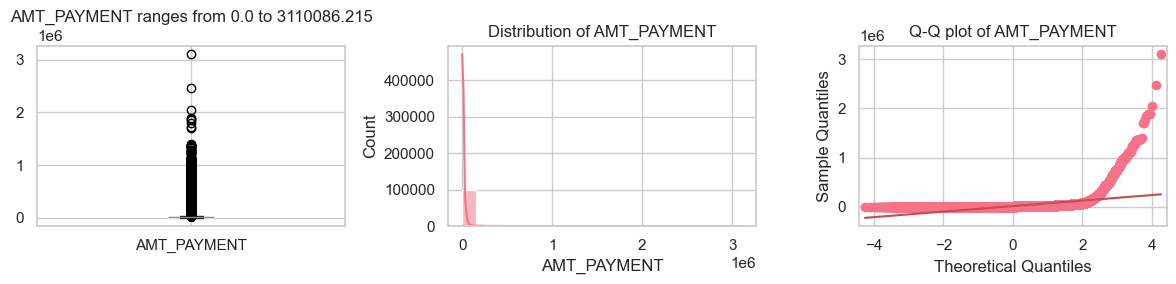

In [8]:
help_visuals.distribution_check(installments_payments.drop(columns=['SK_ID_PREV', 'SK_ID_CURR', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT']).sample(100000, random_state=42))

* Most instalments are 0-50 counts
* Instalment amounts range from 0 to 3 mill. RUB

## Feature engineering
Ideally, the values for time and amount of instalments would align. However, behaviour data can show missed deadlines and missing payer amounts.

In [28]:
installments_payments_overall = duckdb.query("""
    WITH 
    instalments AS (
        SELECT 
            SK_ID_CURR, SK_ID_PREV, 
            SUM(AMT_INSTALMENT) AS AMT_INSTALMENT, 
            COUNT(NUM_INSTALMENT_NUMBER) AS CNT_INSTALMENT
        FROM (
            SELECT DISTINCT 
                SK_ID_CURR, SK_ID_PREV, AMT_INSTALMENT, NUM_INSTALMENT_NUMBER
            FROM installments_payments
        ) A
        GROUP BY SK_ID_CURR, SK_ID_PREV
    ),
    payments AS (
        SELECT SK_ID_CURR, SK_ID_PREV, SUM(AMT_PAYMENT) AS AMT_PAYMENT  
        FROM (
            SELECT DISTINCT SK_ID_CURR, SK_ID_PREV, NUM_INSTALMENT_NUMBER, AMT_PAYMENT 
            FROM installments_payments
        ) A
        GROUP BY SK_ID_CURR, SK_ID_PREV
    ),
    missed_months AS (
        SELECT 
            SK_ID_CURR, SK_ID_PREV, 
            CAST(MIN(MISSED_DEADLINE_DAYS) AS BIGINT) AS MIN_MISSED_DEADLINE_DAYS,
            CAST(AVG(MISSED_DEADLINE_DAYS) AS BIGINT) AS AVG_MISSED_DEADLINE_DAYS,
            CAST(MAX(MISSED_DEADLINE_DAYS) AS BIGINT) AS MAX_MISSED_DEADLINE_DAYS,                                             
            SUM(CAST(MISSED_DEADLINE AS BIGINT)) AS CNT_MISSED_DEADLINE
        FROM (
                SELECT 
                    SK_ID_CURR, SK_ID_PREV,
                    CAST((CAST(DAYS_ENTRY_PAYMENT AS INT) - CAST(DAYS_INSTALMENT AS INT)) AS INT) AS MISSED_DEADLINE_DAYS,
                    (CAST(DAYS_ENTRY_PAYMENT AS INT) > CAST(DAYS_INSTALMENT AS INT)) AS MISSED_DEADLINE
                FROM installments_payments A
        ) A
        GROUP BY SK_ID_CURR, SK_ID_PREV
    )
    SELECT 
        A.SK_ID_PREV, A.SK_ID_CURR, 
        (CAST(B.AMT_PAYMENT AS INT) - CAST(A.AMT_INSTALMENT AS INT)) AS AMOUNT_AFTER_INSTALMENT,
        CASE WHEN CAST(A.AMT_INSTALMENT AS INT) = 0 THEN 1 ELSE 0 END AS ZERO_INSTALMENT_REQ,
        A.CNT_INSTALMENT,
        C.MIN_MISSED_DEADLINE_DAYS, C.AVG_MISSED_DEADLINE_DAYS, C.MAX_MISSED_DEADLINE_DAYS, C.CNT_MISSED_DEADLINE
    FROM instalments A
    FULL OUTER JOIN payments B 
        ON A.SK_ID_CURR = B.SK_ID_CURR AND A.SK_ID_PREV = B.SK_ID_PREV
    FULL OUTER JOIN missed_months C 
        ON A.SK_ID_CURR = C.SK_ID_CURR AND A.SK_ID_PREV = C.SK_ID_PREV
""").to_df()

installments_payments_overall.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,SK_ID_PREV,SK_ID_CURR,AMOUNT_AFTER_INSTALMENT,ZERO_INSTALMENT_REQ,CNT_INSTALMENT,MIN_MISSED_DEADLINE_DAYS,AVG_MISSED_DEADLINE_DAYS,MAX_MISSED_DEADLINE_DAYS,CNT_MISSED_DEADLINE
0,2427876,191503,0,0,74,-19,-5,8,1.0
1,1034517,139439,0,0,23,-31,-5,8,1.0
2,1760948,103316,0,0,6,-36,-27,-5,0.0
3,1484338,103961,0,0,46,-19,16,905,2.0
4,1496986,114735,0,0,83,-30,-2,0,0.0


In [29]:
help_tool.first_look(installments_payments_overall)

Dataset has 997674 observations and 9 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_PREV,int64,0,0.0
SK_ID_CURR,int64,0,0.0
AMOUNT_AFTER_INSTALMENT,int32,0,0.0
ZERO_INSTALMENT_REQ,int32,0,0.0
CNT_INSTALMENT,int64,0,0.0
MIN_MISSED_DEADLINE_DAYS,int64,0,0.0
AVG_MISSED_DEADLINE_DAYS,int64,0,0.0
MAX_MISSED_DEADLINE_DAYS,int64,0,0.0
CNT_MISSED_DEADLINE,float64,0,0.0


AMOUNT_AFTER_INSTALMENT


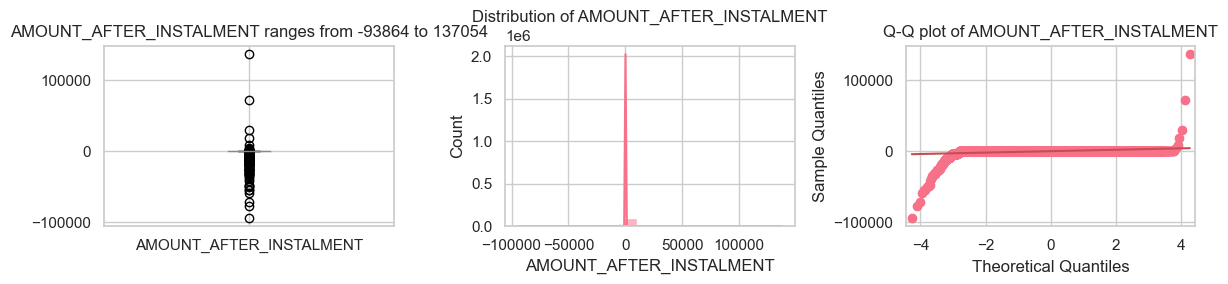

CNT_INSTALMENT


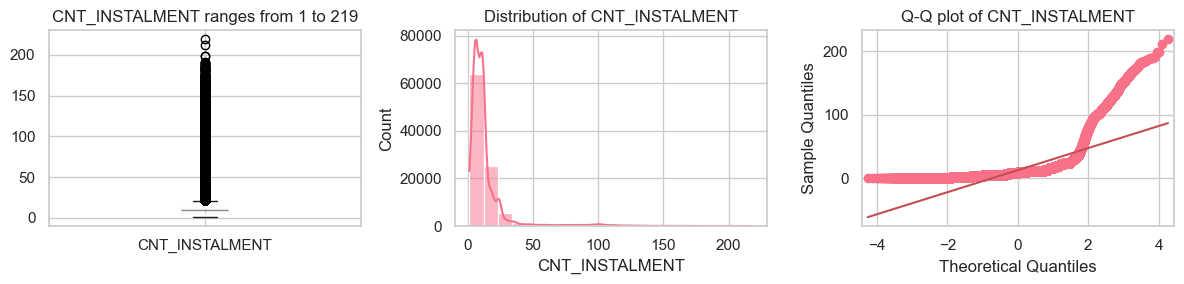

MIN_MISSED_DEADLINE_DAYS


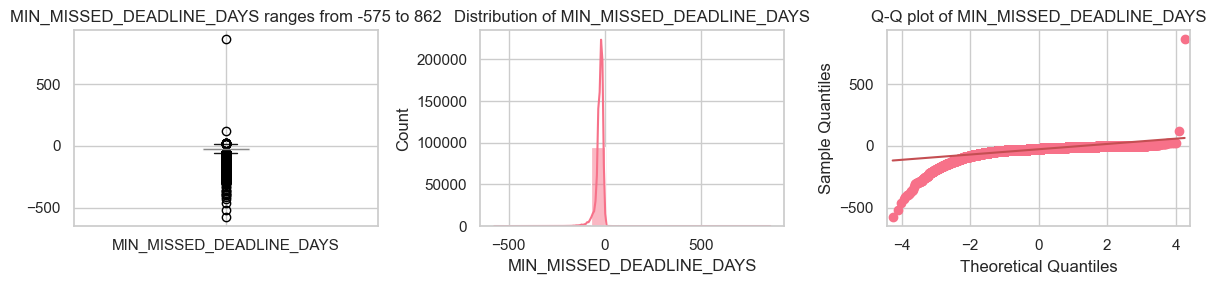

AVG_MISSED_DEADLINE_DAYS


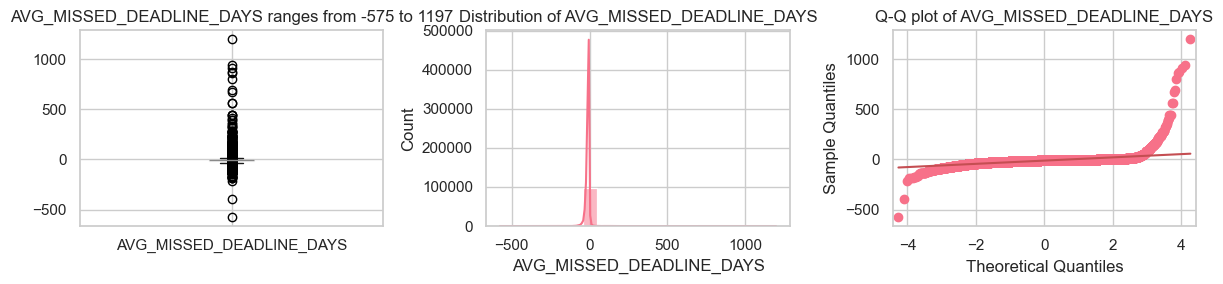

MAX_MISSED_DEADLINE_DAYS


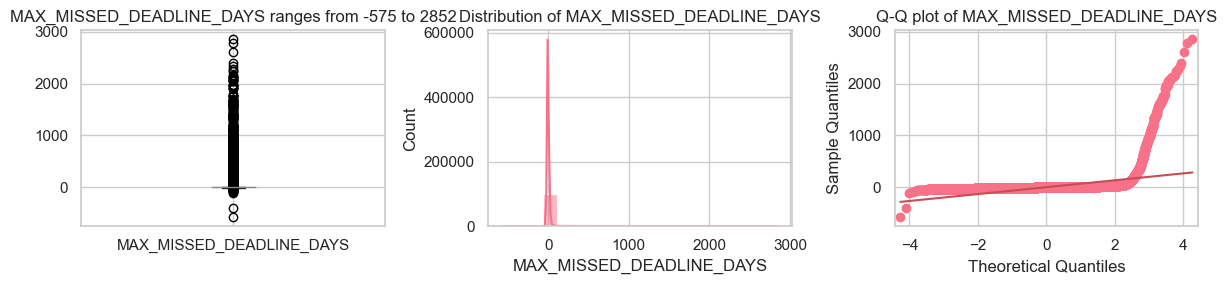

CNT_MISSED_DEADLINE


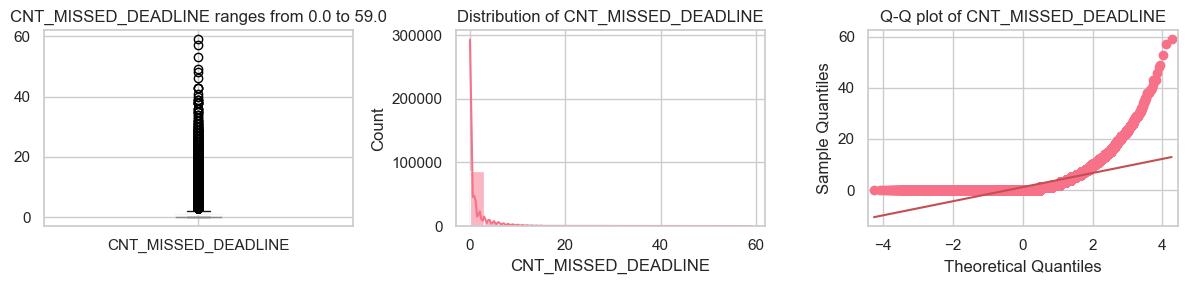

In [30]:
help_visuals.distribution_check(installments_payments_overall.drop(columns=['SK_ID_PREV', 'SK_ID_CURR', 'ZERO_INSTALMENT_REQ']).sample(100000, random_state=42))

* Some users have not payed their debts, some have build up fonds.
* One outlier with > 2 mill of funds left after instalments.
* Some users pay of instalments up to 1.5 years earlier.
* Recoreded instalments are up to 228.
* Most people don't miss deadlines, but theirs delays in instalment payments up to 2871 days.

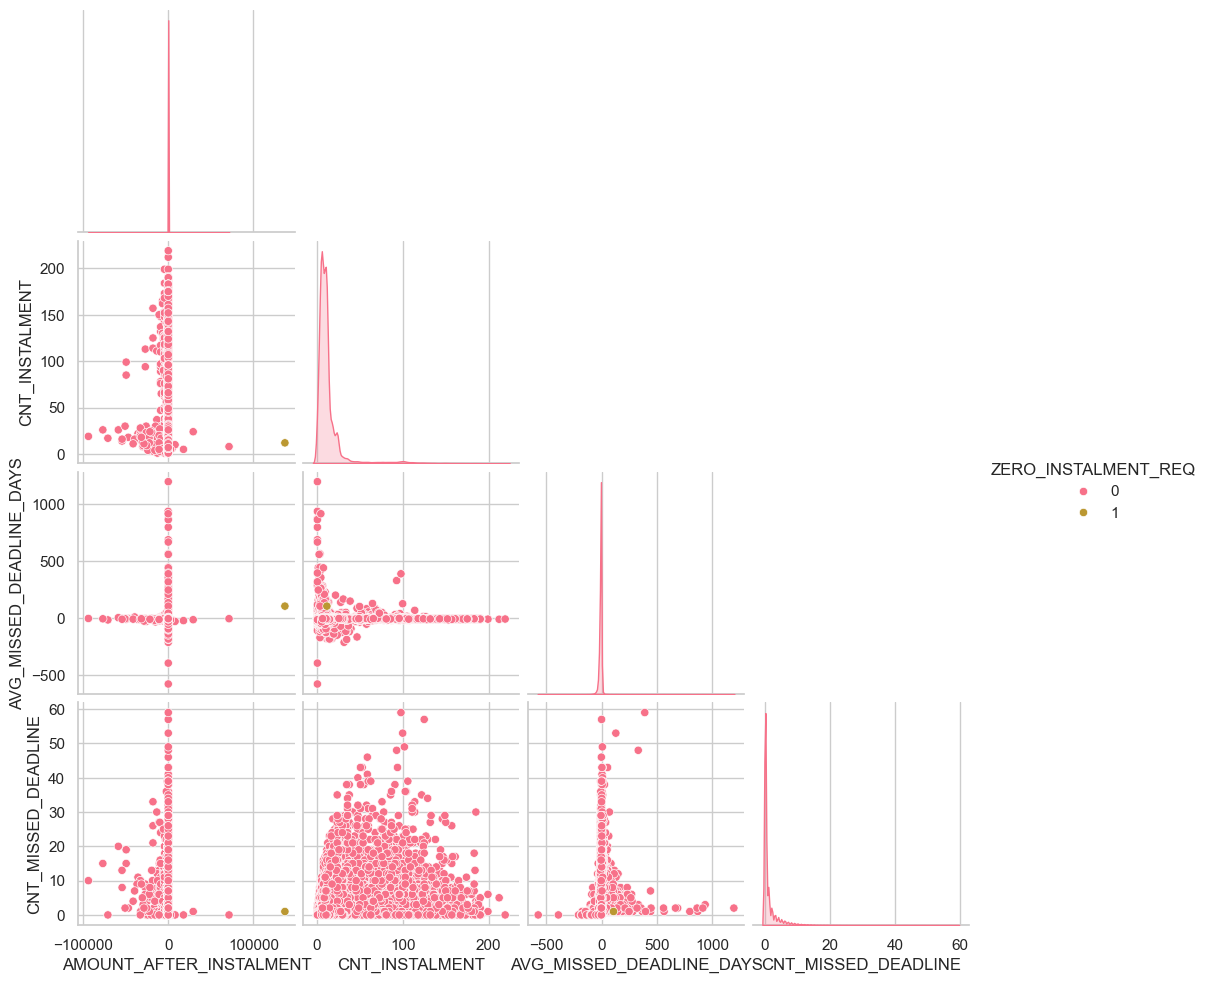

In [33]:
sns.pairplot(installments_payments_overall.drop(columns=['SK_ID_PREV', 'SK_ID_CURR', 'MIN_MISSED_DEADLINE_DAYS', 'MAX_MISSED_DEADLINE_DAYS']).sample(100000, random_state=42), corner=True, hue='ZERO_INSTALMENT_REQ')
plt.show()